In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.8 MB/s eta 0:00:00


In [2]:
!pip install -q datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00


In [3]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 4.5 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset

# this dataset uses the new Image feature :)
dataset = load_dataset("./layoutlmv3.py")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 9
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 4
    })
})

In [5]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['doc_number', 'doc_date', 'supplier_name', 'supplier_phone', 'receiver_tax_id'], id=None), length=-1, id=None),
 'image_path': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None)}

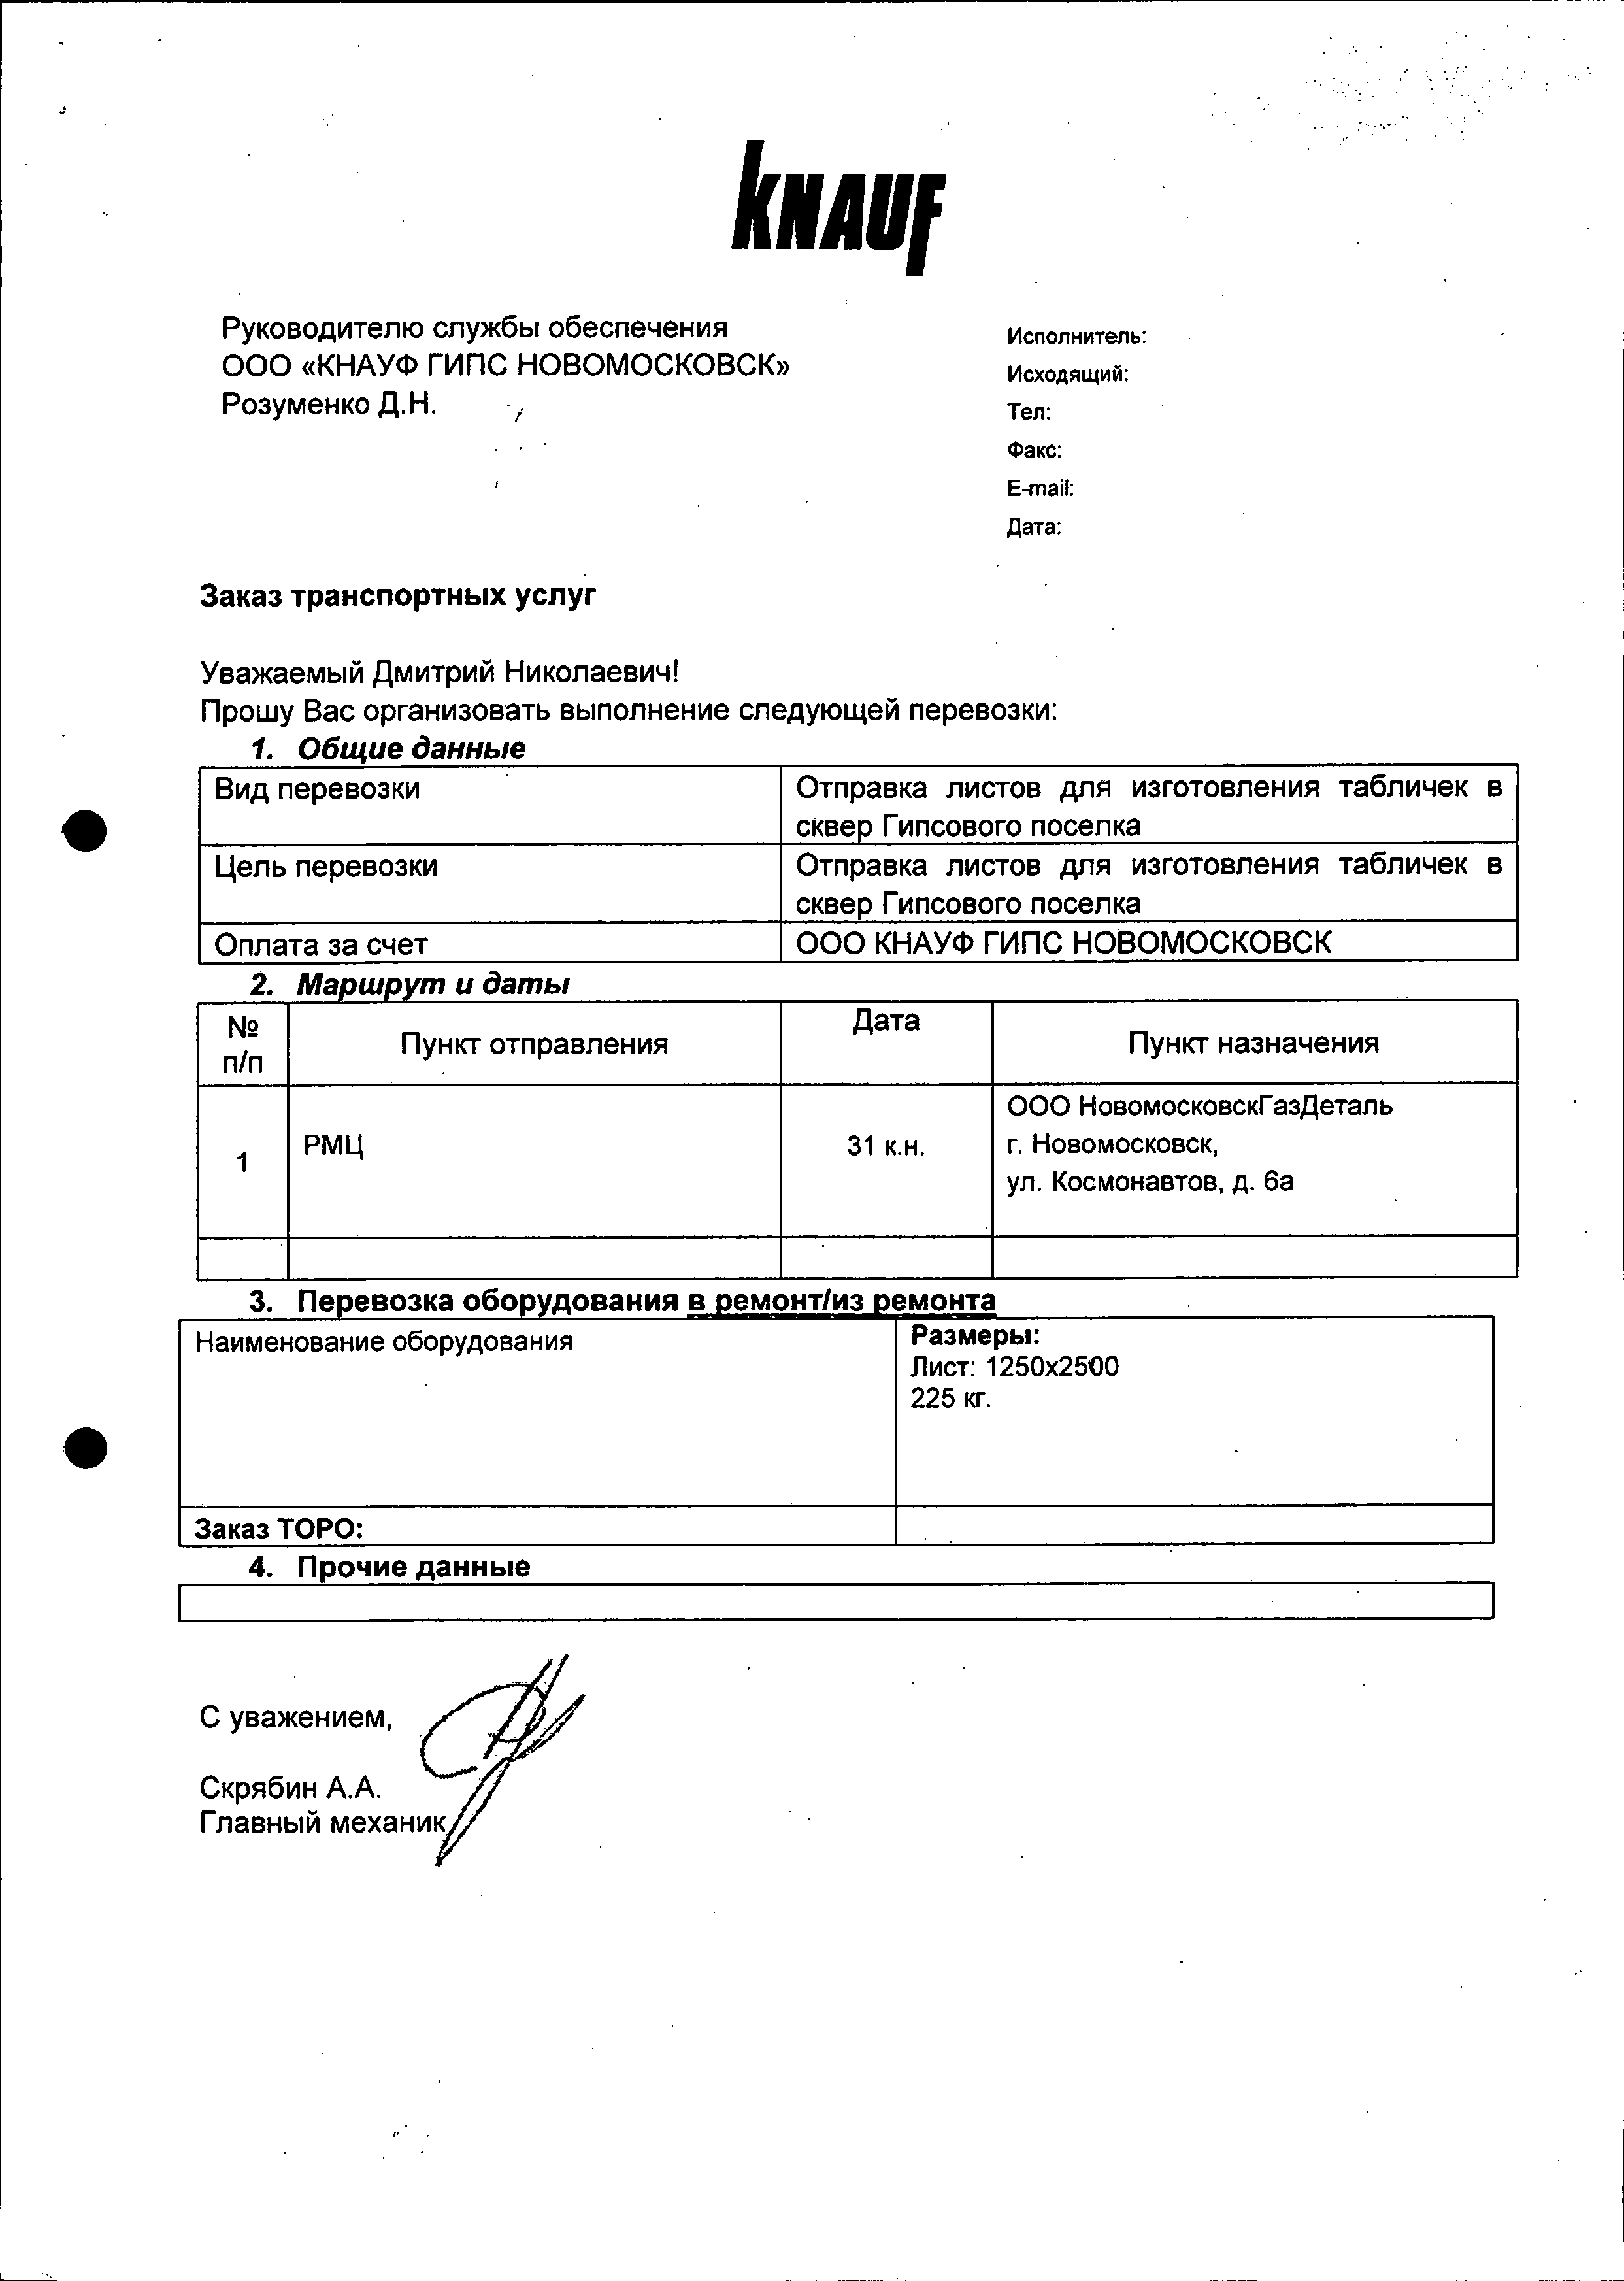

In [192]:
example = dataset["train"][0]
example["image"]

In [7]:
qq = example["image"].convert("RGB")
qq.size

(2485, 3490)

In [190]:
from  PIL import Image
qqq = Image.open(r"./layoutlmv3/doc-0001.jpg").convert("RGB")
qqq.size

(2488, 3477)

In [191]:
words, boxes, ner_tags = example["tokens"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['1428', '04.08.2022', 'VngueugyanbHbiit', 'npeanpvHumatenb', 'Opnos', 'Anexcanap', 'Esrexbesniy', '711603577035']
[[472, 275, 515, 286], [549, 275, 649, 286], [185, 38, 317, 49], [323, 39, 461, 49], [467, 37, 516, 49], [521, 37, 604, 49], [609, 37, 697, 46], [143, 65, 253, 75]]
[0, 1, 2, 2, 2, 2, 2, 4]


In [10]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

C:\Users\ABurilin\Projects\elar\notebook\dai\layoutlmv3\venv\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [12]:
print(label_list)

['doc_number', 'doc_date', 'supplier_name', 'supplier_phone', 'receiver_tax_id']


In [13]:
print(id2label)

{0: 'doc_number', 1: 'doc_date', 2: 'supplier_name', 3: 'supplier_phone', 4: 'receiver_tax_id'}


In [14]:
def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [15]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

In [17]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 9
})

In [18]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> Cxpar6un A.A. Posymeuko 4.H.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [19]:
train_dataset.set_format("torch")

In [20]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [21]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 4
})

In [22]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

'<s> Ha cbespalib 2005</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [23]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 C 2
x -100
par -100
6 -100
un -100
 A 2
. -100
A -100
. -100
 Pos 2
y -100
me -100
uko -100
 4 2
. -100
H -100
. -100
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad

In [36]:
#!pip install evaluate

In [37]:
from evaluate import load

In [39]:
import evaluate

In [40]:
#from datasets import load_metric

#metric = load_metric("seqeval")
metric = evaluate.load("seqeval")

In [41]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [42]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [44]:
# !pip install accelerate -U

In [45]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

max_steps is given, it will override any value given in num_train_epochs


In [46]:
trainer.train()

C:\Users\ABurilin\Projects\elar\notebook\dai\layoutlmv3\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: doc_date seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\ABurilin\Projects\elar\notebook\dai\layoutlmv3\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: doc_number seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\ABurilin\Projects\elar\notebook\dai\layoutlmv3\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: supplier_name seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\ABurilin\Projects\elar\notebook\dai\layoutlmv3\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: supplier_phone seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\ABurilin\Projects\elar\notebook\dai\layoutlmv3\venv\lib\site-packages\

TrainOutput(global_step=1000, training_loss=0.025794643849134446, metrics={'train_runtime': 3957.9488, 'train_samples_per_second': 0.505, 'train_steps_per_second': 0.253, 'total_flos': 474481113292800.0, 'train_loss': 0.025794643849134446, 'epoch': 200.0})

In [429]:
image_path = '../assets/test_act.jpg'
image = Image.open(image_path).convert("RGB")

In [505]:
image_path = '../assets/test_act.jpg'
image = Image.open(image_path).convert("RGB")
example = {'id': '1',
 'tokens': ['1428',
  '4',
  'aprycta',
  '2022',
  'r.',
  'Vin',
  'Opnos',
  'Anexcangp',
  'Eprenbesuy',
  '19,Ten.8-910-704-09-21',
  '711603577035'],
 'bboxes': [[425, 77, 460, 86],
  [488, 77, 497, 86],
  [503, 70, 563, 90],
  [569, 77, 605, 86],
  [611, 79, 621, 86],
  [311, 138, 330, 146],
  [336, 138, 385, 149],
  [390, 138, 473, 149],
  [479, 138, 566, 147],
  [127, 446, 301, 457],
  [150, 460, 260, 469]],
 'ner_tags': [0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 4],
 'image_path': '../assets/test_act.jpg',
 'image': image}

In [47]:
trainer.evaluate()

C:\Users\ABurilin\Projects\elar\notebook\dai\layoutlmv3\venv\lib\site-packages\transformers\modeling_utils.py:1141: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


C:\Users\ABurilin\Projects\elar\notebook\dai\layoutlmv3\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: doc_date seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\ABurilin\Projects\elar\notebook\dai\layoutlmv3\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: doc_number seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\ABurilin\Projects\elar\notebook\dai\layoutlmv3\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: supplier_name seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\ABurilin\Projects\elar\notebook\dai\layoutlmv3\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: supplier_phone seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\ABurilin\Projects\elar\notebook\dai\layoutlmv3\venv\lib\site-packages\

{'eval_loss': 5.106804847717285,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_f1': 0.0,
 'eval_accuracy': 0.45161290322580644,
 'eval_runtime': 2.9058,
 'eval_samples_per_second': 1.377,
 'eval_steps_per_second': 0.688,
 'epoch': 200.0}

In [48]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("./test/checkpoint-1000")

In [453]:
image_path = '../assets/test_act.jpg'
image = Image.open(image_path).convert("RGB")

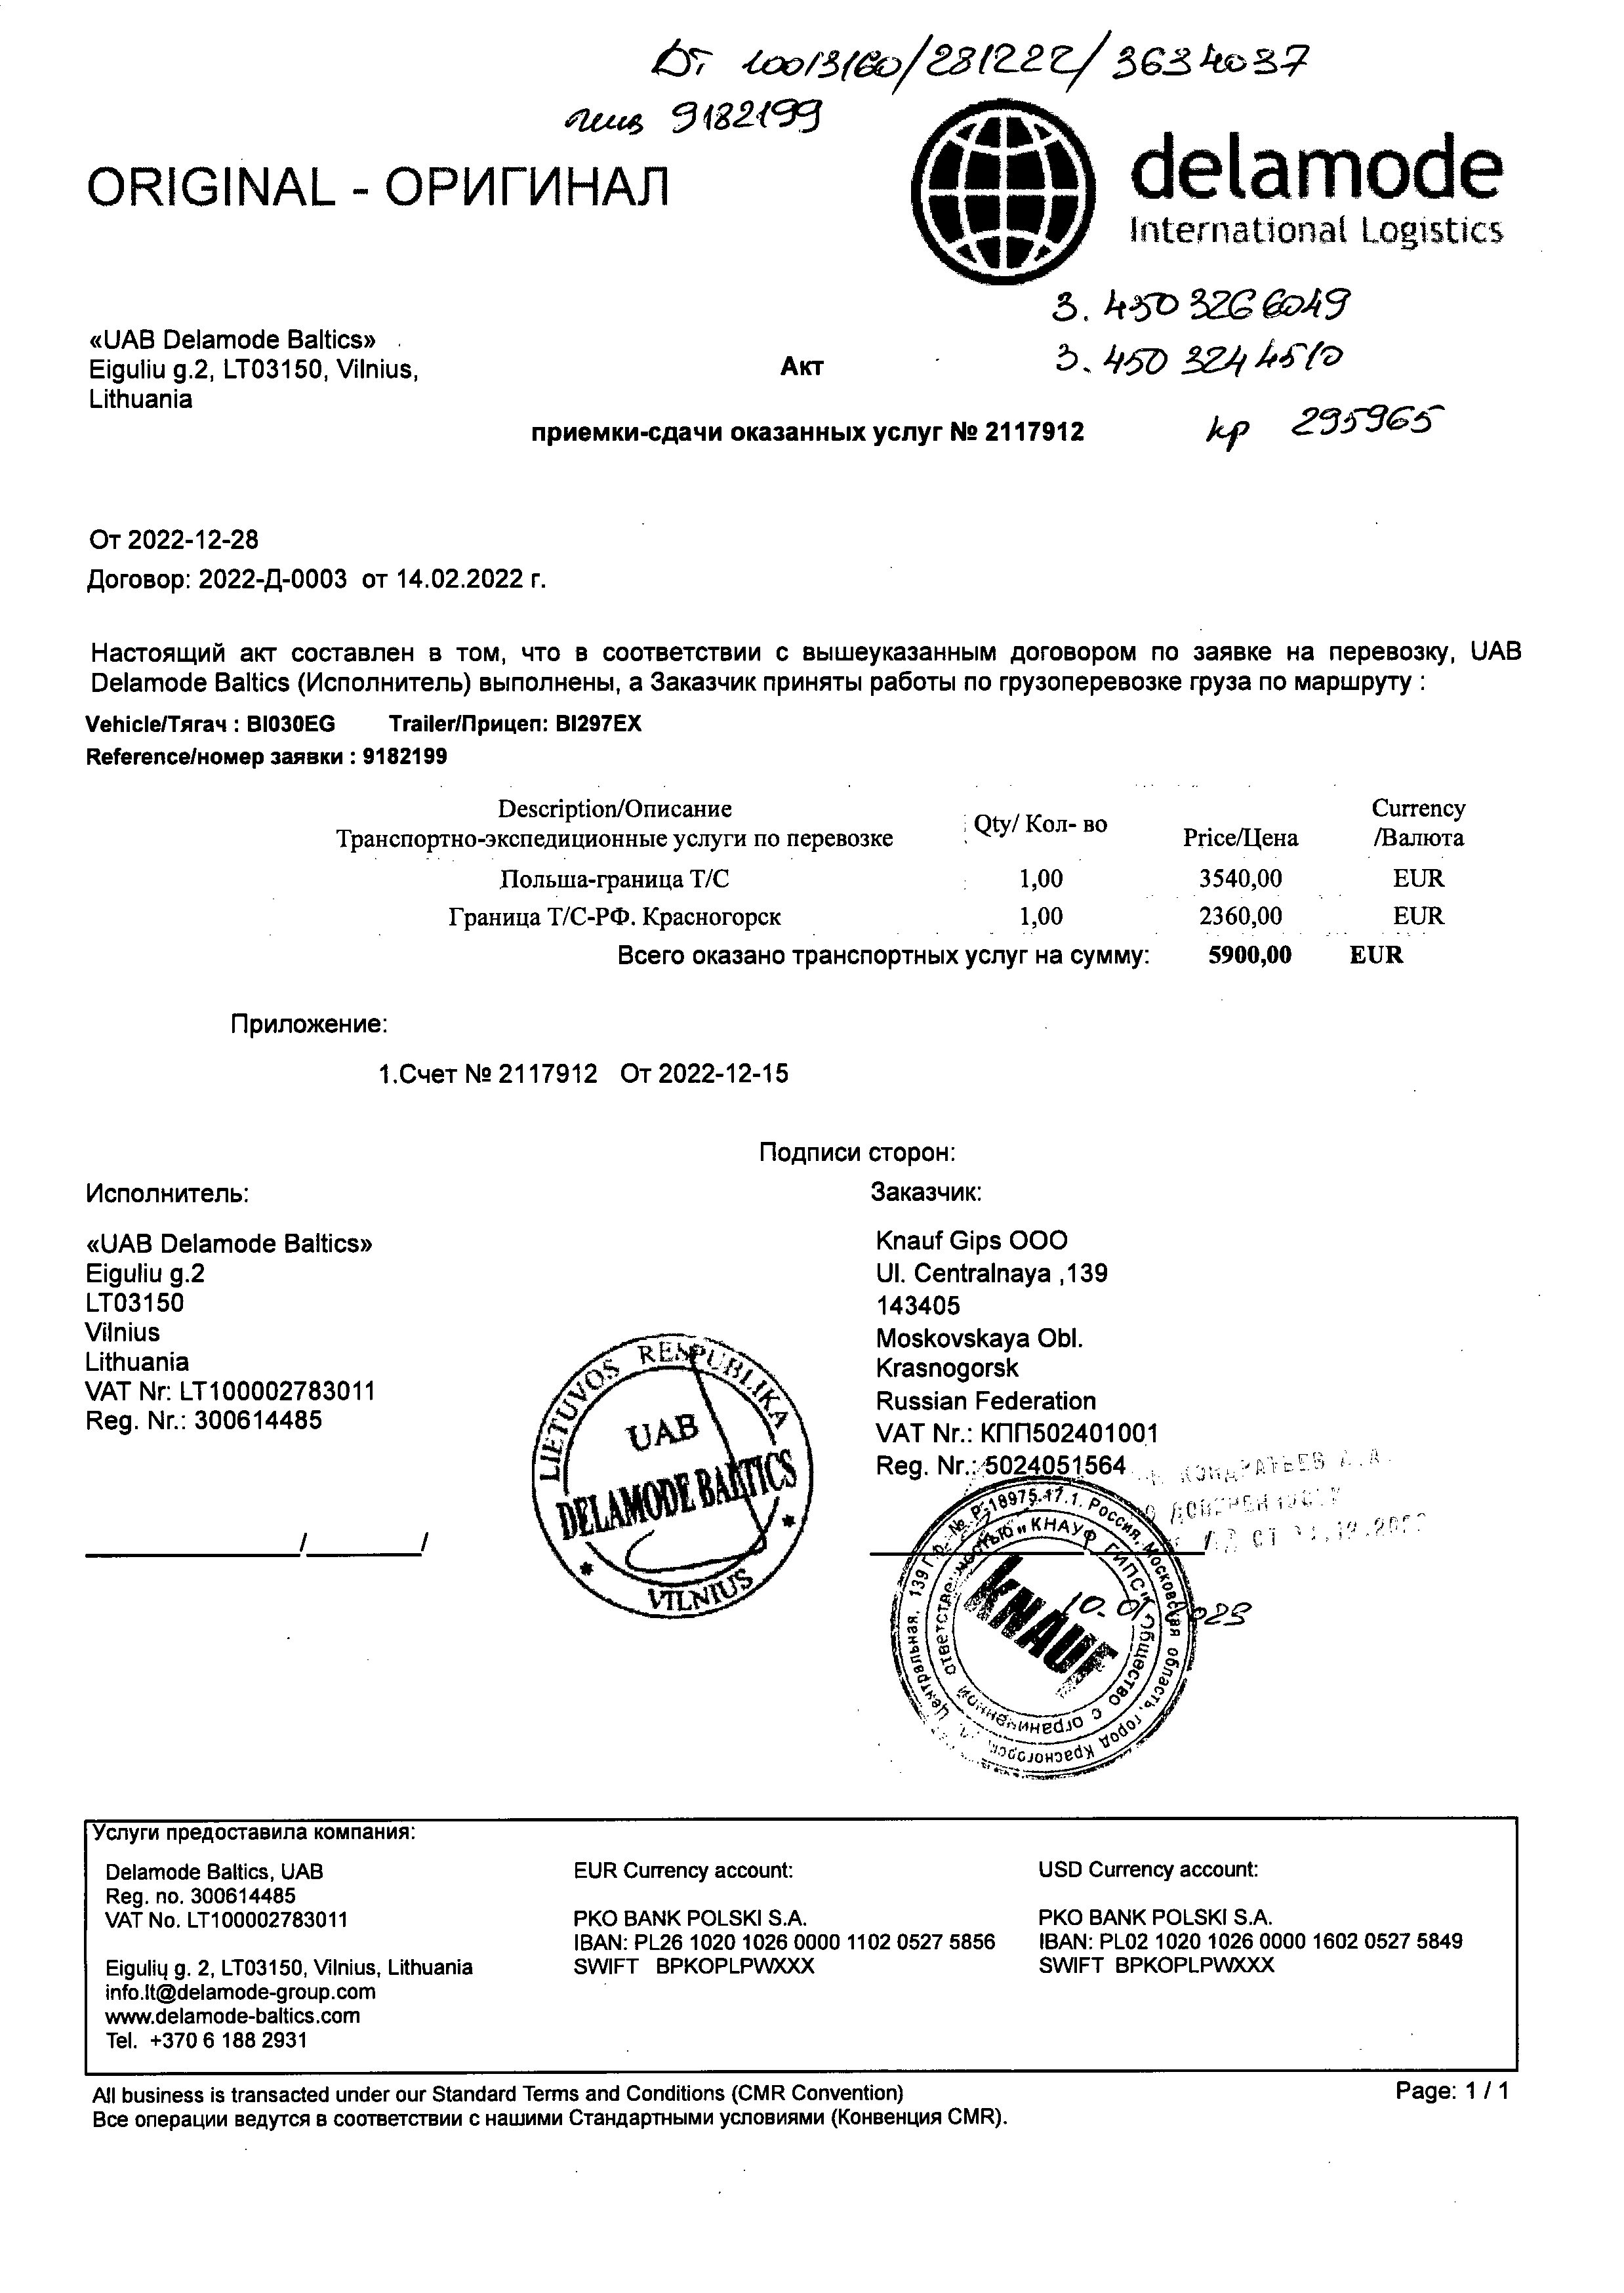

In [506]:
image

In [433]:
#example

In [495]:
example = dataset["test"][1]
print(example.keys())

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'])


In [496]:
#example

In [507]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 43])
attention_mask torch.Size([1, 43])
bbox torch.Size([1, 43, 4])
labels torch.Size([1, 43])
pixel_values torch.Size([1, 3, 224, 224])


In [508]:
with torch.no_grad():
  outputs = model(**encoding)

In [509]:
logits = outputs.logits
logits.shape

torch.Size([1, 43, 5])

In [510]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

[4, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4]


In [511]:
labels = encoding.labels.squeeze().tolist()
print(labels)

[-100, 0, -100, 1, 1, -100, -100, -100, 1, 1, -100, 2, 2, -100, 2, -100, -100, -100, -100, 2, -100, -100, -100, 3, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 4, -100, -100, -100, -100, -100, -100]


In [512]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

#true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
#true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
#true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) ]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100 ]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) ]



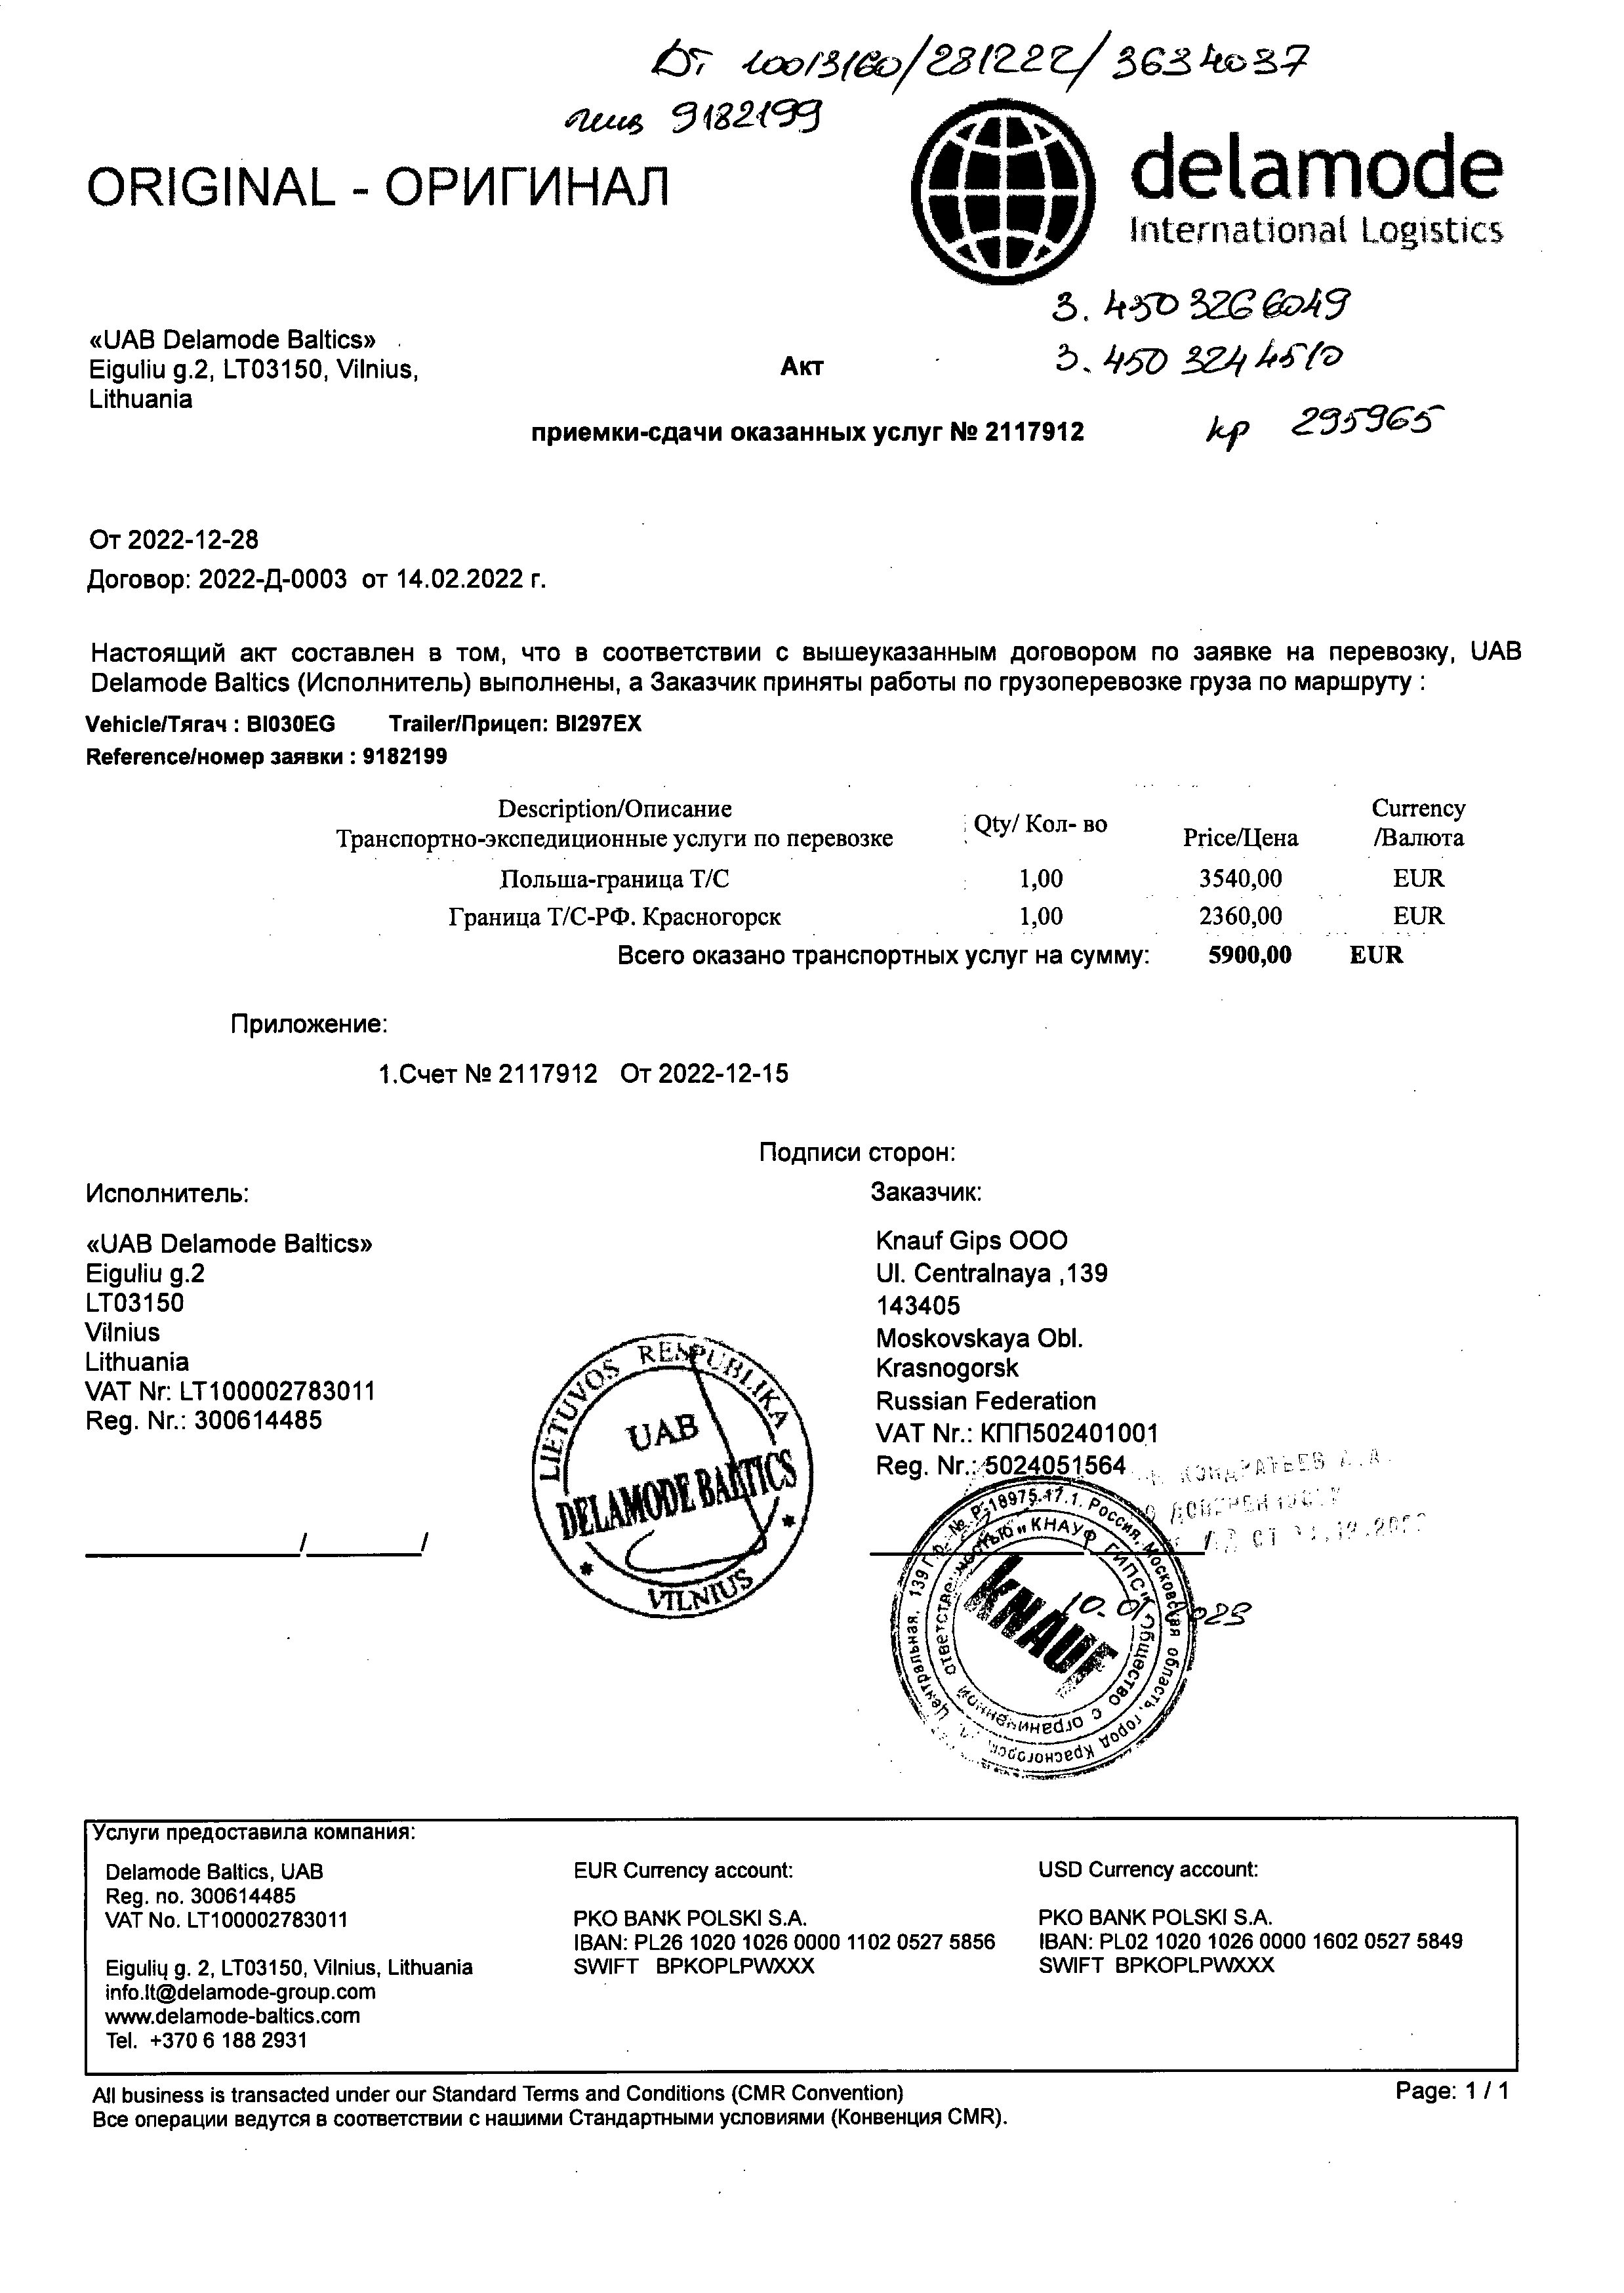

In [513]:
image

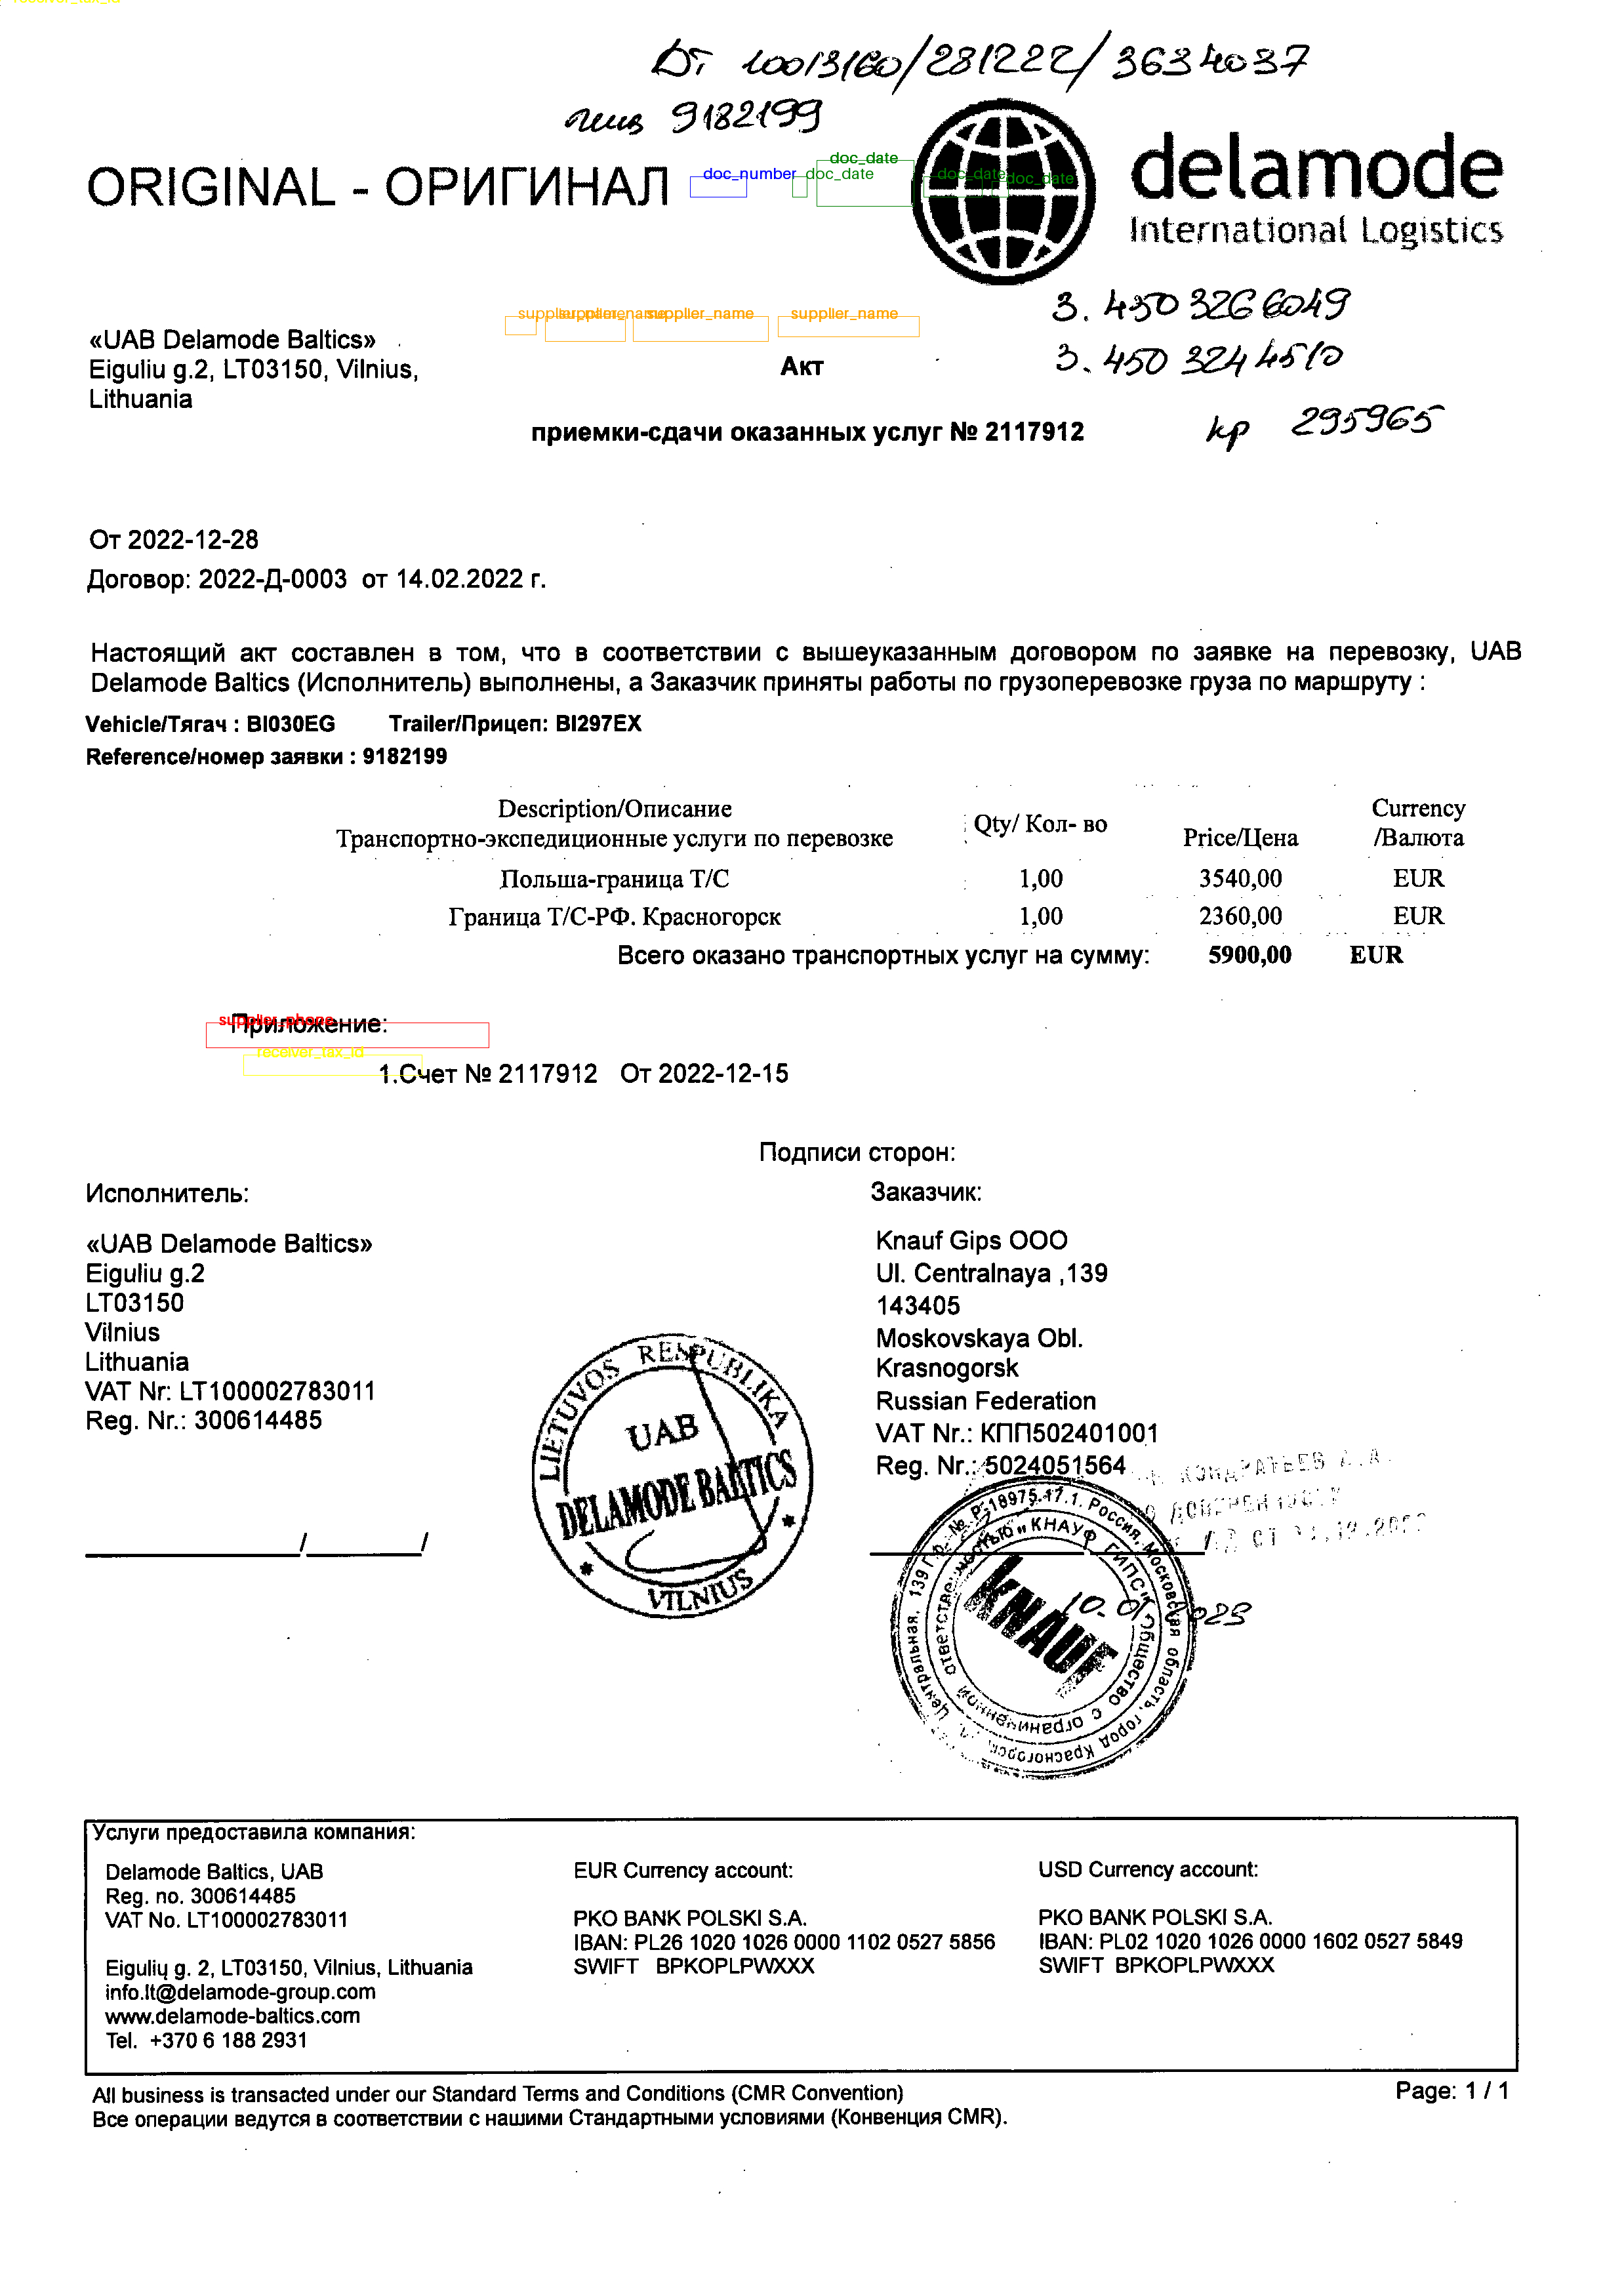

In [514]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default(size=24)

def iob_to_label(label):
    label = label
    if not label:
      return 'other'
    return label

label2color = {'doc_number':'blue', 'doc_date':'green', 'supplier_name':'orange','supplier_phone':'red', 'receiver_tax_id':'yellow'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 20, box[1] - 20), text=predicted_label, fill=label2color[predicted_label], font=font)

image

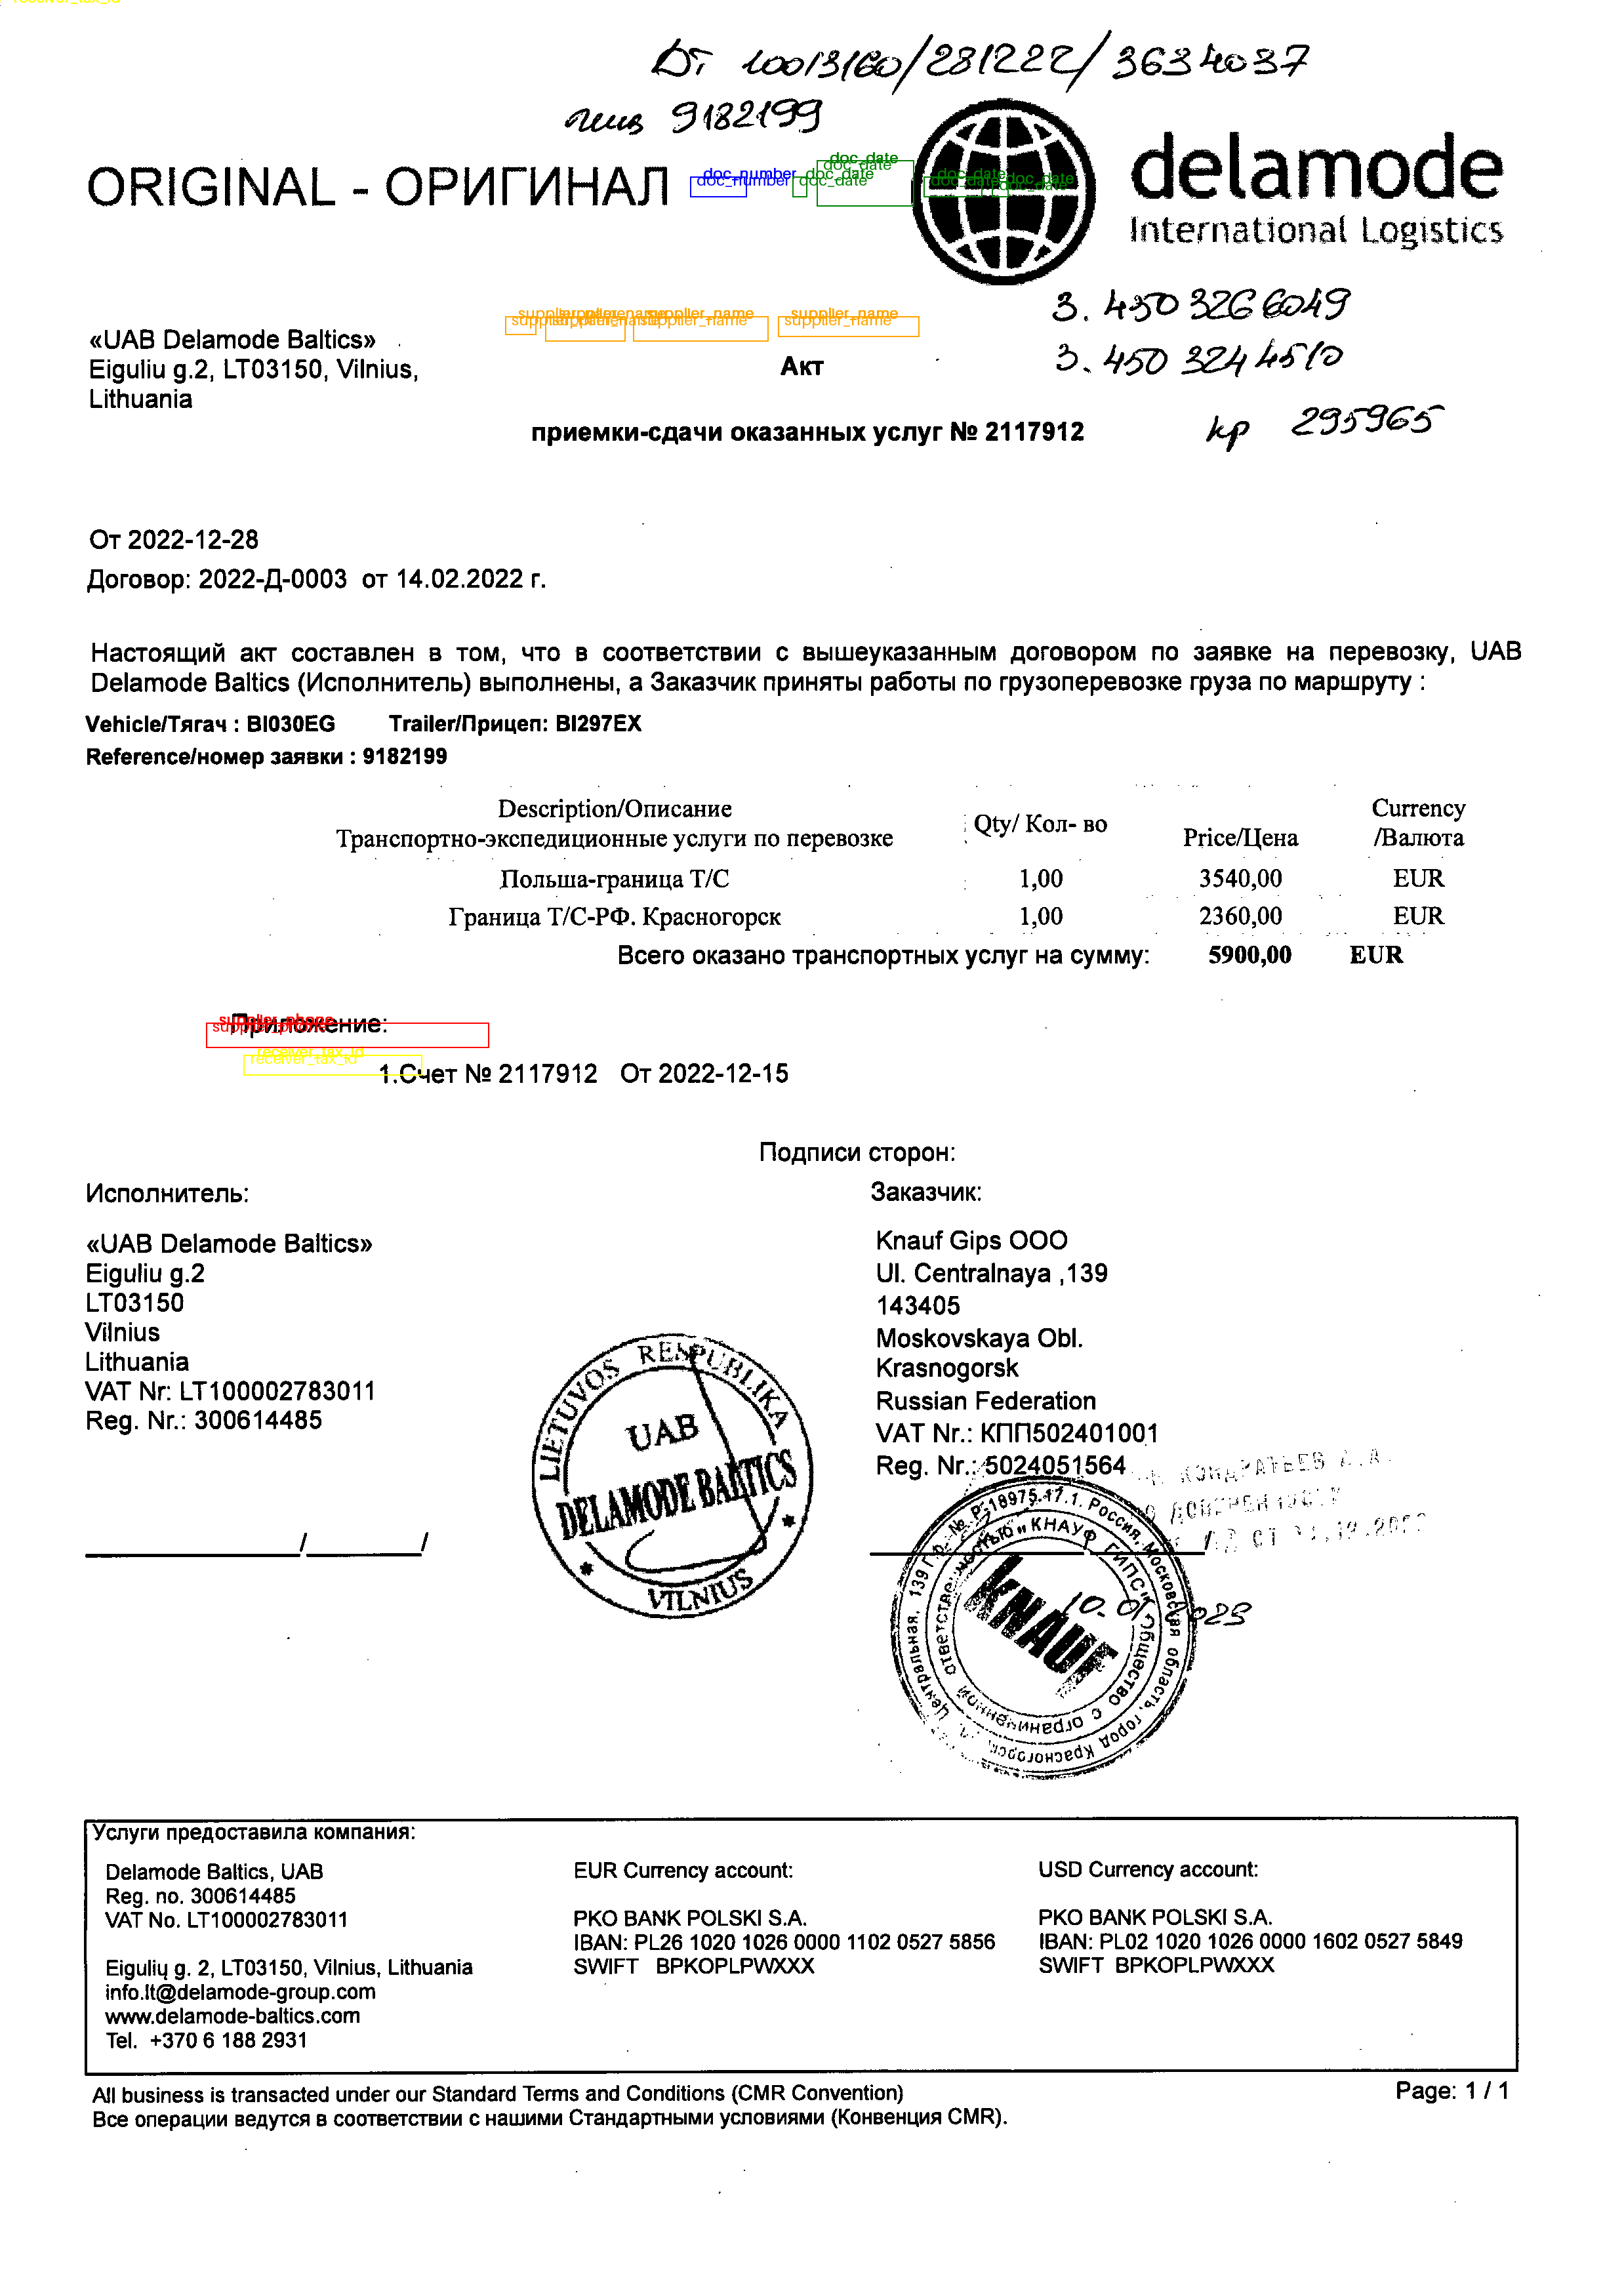

In [388]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image

In [164]:
example

{'id': '0',
 'tokens': ['Cxpar6un', 'A.A.', 'Posymeuko', '4.H.'],
 'bboxes': [[123, 778, 194, 791],
  [200, 778, 234, 788],
  [137, 171, 227, 184],
  [232, 171, 268, 183]],
 'ner_tags': [2, 2, 2, 2],
 'image_path': './layoutlmv3\\doc-0005.jpg',
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2485x3490>}

In [165]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 9
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 4
    })
})